<a href="https://colab.research.google.com/github/piiop/final_project/blob/main/cnn_model_training2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Standard libraries
import os
import math
import pickle
import shutil
import io

# Data manipulation and analysis
import numpy as np
import pandas as pd
from tqdm import tqdm

# Image processing
from PIL import Image

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import the preprocessed data
imgs = pd.read_csv("/content/training_imageset2.csv")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11226 entries, 0 to 11225
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movement   11226 non-null  object
 1   file_path  11226 non-null  object
dtypes: object(2)
memory usage: 175.5+ KB


In [6]:
imgs['file_path'].head()

,file_path
0,resized_imgs\57728a68edc2cb388010fa7e.jpg
1,resized_imgs\57728a68edc2cb388010fa90.jpg
2,resized_imgs\57728a69edc2cb388010faa0.jpg
3,resized_imgs\57728a69edc2cb388010fab0.jpg
4,resized_imgs\57728a69edc2cb388010fac0.jpg


Load the files from Google Drive into Colab runtime

In [31]:
def load_files_to_colab(df, dest_base_path='/content/local_images/'):
    """
    Copy files from Google Drive to Colab runtime directory and update DataFrame with local paths.

    Args:
        df: DataFrame containing original file paths
        dest_base_path: Base path for local storage in Colab

    Returns:
        DataFrame with new column containing local file paths
    """
    os.makedirs(dest_base_path, exist_ok=True)

    # Create a copy of the DataFrame to avoid modifying the original
    df_local = df.copy()

    # Add new column for local paths
    df_local['local_path'] = ''

    for idx, row in tqdm(df_local.iterrows(), total=len(df_local), desc="Copying files"):
        relative_path = row['file_path'].replace('\\', '/')
        file_name = relative_path.split('/')[-1]
        source_path = f'/content/drive/MyDrive/art_classification/{relative_path}'
        dest_path = os.path.join(dest_base_path, file_name)

        # Copy file if it doesn't already exist
        if not os.path.exists(dest_path):
            shutil.copy2(source_path, dest_path)

        # Update DataFrame with local path
        df_local.at[idx, 'local_path'] = dest_path

    return df_local

# Update your DataFrame with local paths
imgs_local = load_files_to_colab(imgs)

Copying files: 100%|██████████| 11226/11226 [00:00<00:00, 12245.05it/s]


Dropping 'contemporary' from the styles to improve model percentile

In [71]:
imgs_dropped = imgs_local[~imgs_local['movement'].isin(['contemporary'])]

Convert the image files to floating point numpy arrays and normalize. And load the into the dataframe in batches for training.

In [72]:
# Convert to floating point and normalize
def load_and_normalize_image(file_path):
    """
    Load image from file_path, convert to float32 array and normalize to [0, 1] range

    Args:
        file_path (str): Path to the image file

    Returns:
        numpy.ndarray: Normalized image array of shape (height, width, 3) in float32
    """
    # Load image
    img = Image.open(file_path)

    # Convert to RGB if not already
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Convert to numpy array and change type to float32
    img_array = np.array(img, dtype=np.float32)

    # Normalize to [0, 1] range
    img_array = img_array / 255.0

    return img_array

import time

def load_images_in_batches(dataframe, batch_size=1000):
    """Load images in batches with timing information"""
    total_batches = (len(dataframe) // batch_size) + 1
    all_arrays = []

    for i in range(0, len(dataframe), batch_size):
        batch_start_time = time.time()
        batch = dataframe.iloc[i:i+batch_size]
        batch_arrays = []

        print(f"\nProcessing batch {i//batch_size + 1}/{total_batches}")

        for idx, file_path in enumerate(batch['local_path']):
            start_time = time.time()
            try:
                img_array = load_and_normalize_image(file_path)
                batch_arrays.append(img_array)
                load_time = time.time() - start_time
                if load_time > 1.0:  # Log slow loads
                    print(f"\nSlow load ({load_time:.2f}s): {file_path}")
            except Exception as e:
                print(f"\nError processing {file_path}: {str(e)}")
                continue

            if idx % 10 == 0:
                print(f"Progress: {idx}/{len(batch)}", end='\r')

        all_arrays.extend(batch_arrays)
        batch_time = time.time() - batch_start_time
        print(f"\nBatch {i//batch_size + 1} completed in {batch_time:.2f} seconds")
        print(f"Average time per image: {batch_time/len(batch):.2f} seconds")

    return np.array(all_arrays)

# Load images using updated DataFrame
image_arrays = load_images_in_batches(imgs_dropped, batch_size=1000)


Processing batch 1/11
Progress: 990/1000
Batch 1 completed in 1.42 seconds
Average time per image: 0.00 seconds

Processing batch 2/11
Progress: 990/1000
Batch 2 completed in 1.40 seconds
Average time per image: 0.00 seconds

Processing batch 3/11
Progress: 990/1000
Batch 3 completed in 1.42 seconds
Average time per image: 0.00 seconds

Processing batch 4/11
Progress: 990/1000
Batch 4 completed in 1.38 seconds
Average time per image: 0.00 seconds

Processing batch 5/11
Progress: 990/1000
Batch 5 completed in 1.39 seconds
Average time per image: 0.00 seconds

Processing batch 6/11
Progress: 990/1000
Batch 6 completed in 1.42 seconds
Average time per image: 0.00 seconds

Processing batch 7/11
Progress: 990/1000
Batch 7 completed in 1.42 seconds
Average time per image: 0.00 seconds

Processing batch 8/11
Progress: 990/1000
Batch 8 completed in 1.43 seconds
Average time per image: 0.00 seconds

Processing batch 9/11
Progress: 990/1000
Batch 9 completed in 1.33 seconds
Average time per ima

In [73]:
# Define X and y
X = image_arrays
y = imgs_dropped['movement']

In [74]:
# Get our list of styles in order
unique_styles = imgs_dropped['movement'].unique()
print("Style order:")
for i, style in enumerate(unique_styles):
    print(f"{i}: {style}")

Style order:
0: naive_art
1: baroque
2: rococo
3: romanticism
4: art_deco
5: american_realism
6: art_nouveau
7: expressionism
8: post_impressionism
9: high_renaissance
10: cubism
11: abstract_expressionism
12: art_informel
13: mannerism
14: northern_renaissance
15: surrealism
16: symbolism
17: early_renaissance
18: modernism
19: neo_romantic
20: ukiyo_e
21: impressionism
22: pop_art
23: fauvism
24: neoclassicism
25: minimalism


In [82]:
# Split the training dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=99)

In [83]:
# First convert strings to numbers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Then one-hot using tensorflows method
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

print("y_train_cat shape:", y_train_cat.shape)
print("y_test_cat shape:", y_test_cat.shape)

y_train_cat shape: (7578, 26)
y_test_cat shape: (3248, 26)


In [84]:
# Convert list/series of arrays into a single 4D tensor
X_train = np.stack(X_train)
X_test = np.stack(X_test)

# Check shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (7578, 256, 256, 3)
X_test shape: (3248, 256, 256, 3)


In [88]:
# Define input layer
inputs = keras.Input(shape=(256, 256, 3))

# Define L2 regularizer
l2_reg = keras.regularizers.l2(0.00001)

model = keras.Sequential([
   inputs,

   # First Conv Block
   layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg),
   layers.BatchNormalization(),
   layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg),
   layers.BatchNormalization(),
   layers.MaxPooling2D((2, 2)),
   layers.Dropout(0.2),

   # Second Conv Block
   layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg),
   layers.BatchNormalization(),
   layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg),
   layers.BatchNormalization(),
   layers.MaxPooling2D((2, 2)),
   layers.Dropout(0.2),

   # Third Conv Block
   layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg),
   layers.BatchNormalization(),
   layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg),
   layers.BatchNormalization(),
   layers.MaxPooling2D((2, 2)),
   layers.Dropout(0.3),

   # Fourth Conv Block
   layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg),
   layers.BatchNormalization(),
   layers.MaxPooling2D((2, 2)),
   layers.Dropout(0.3),

   # Global Average Pooling
   layers.GlobalAveragePooling2D(),

   # Dense layers
   layers.Dense(256, activation='relu', kernel_regularizer=l2_reg),
   layers.BatchNormalization(),
   layers.Dropout(0.4),
   layers.Dense(26, activation='softmax')
])

# Define learning rate schedule function
def lr_schedule(epoch):
   initial_lr = 0.001
   drop_rate = 0.5
   epochs_drop = 8.0
   lr = initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))
   return lr

# Add callbacks
early_stopping = keras.callbacks.EarlyStopping(
   monitor='val_loss',
   patience=5,
   restore_best_weights=True
)

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

# Compile the model
model.compile(
   optimizer='adam',
   loss='categorical_crossentropy',
   metrics=['accuracy']
)

# Train the model
history = model.fit(
   X_train,
   y_train_cat,
   validation_data=(X_test, y_test_cat),
   epochs=40,
   batch_size=36,
   callbacks=[early_stopping, lr_callback]
)

Epoch 1/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 77s 206ms/step - accuracy: 0.0831 - loss: 3.7165 - val_accuracy: 0.0366 - val_loss: 4.6406 - learning_rate: 0.0010
Epoch 2/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.1082 - loss: 3.3245 - val_accuracy: 0.0958 - val_loss: 3.4765 - learning_rate: 0.0010
Epoch 3/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.1236 - loss: 3.1502 - val_accuracy: 0.0961 - val_loss: 3.2294 - learning_rate: 0.0010
Epoch 4/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.1525 - loss: 2.9677 - val_accuracy: 0.1579 - val_loss: 3.0691 - learning_rate: 0.0010
Epoch 5/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.1803 - loss: 2.8248 - val_accuracy: 0.0896 - val_loss: 4.1922 - learning_rate: 0.0010
Epoch 6/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.2046 - loss: 2.7159 - val_accuracy: 0.1977 - val_loss: 2.8637 - learning_rate: 0.0010
Epoch 7/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.2176 - 

In [89]:
#Evaluate the model using the testing data
model.evaluate(X_test, y_test_cat)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4666 - loss: 1.8037


[1.8117306232452393, 0.46336206793785095]

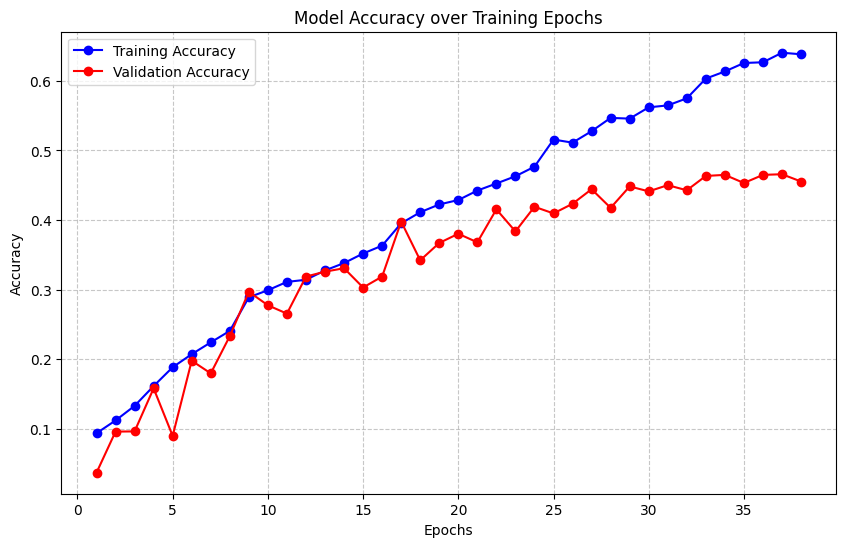

Final Training Accuracy: 0.6383
Final Validation Accuracy: 0.4554


In [90]:
# Plot training history

# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(acc) + 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')

plt.title('Model Accuracy over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Add horizontal and vertical gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Print final accuracies
print(f'Final Training Accuracy: {acc[-1]:.4f}')
print(f'Final Validation Accuracy: {val_acc[-1]:.4f}')

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
Classification Report:
                        precision  recall  f1-score   support
naive_art                   0.392   0.529     0.451   138.000
baroque                     0.365   0.292     0.324   120.000
rococo                      0.874   0.692     0.772   120.000
romanticism                 0.322   0.325     0.324   120.000
art_deco                    0.350   0.408     0.377   120.000
american_realism            0.577   0.342     0.429   120.000
art_nouveau                 0.389   0.282     0.327   124.000
expressionism               0.503   0.614     0.553   140.000
post_impressionism          0.377   0.455     0.412   132.000
high_renaissance            0.398   0.325     0.358   120.000
cubism                      0.536   0.285     0.372   130.000
abstract_expressionism      0.350   0.632     0.450   133.000
art_informel                0.385   0.575     0.462   120.000
mannerism                   0.681   0.706     0.693   136.000
north

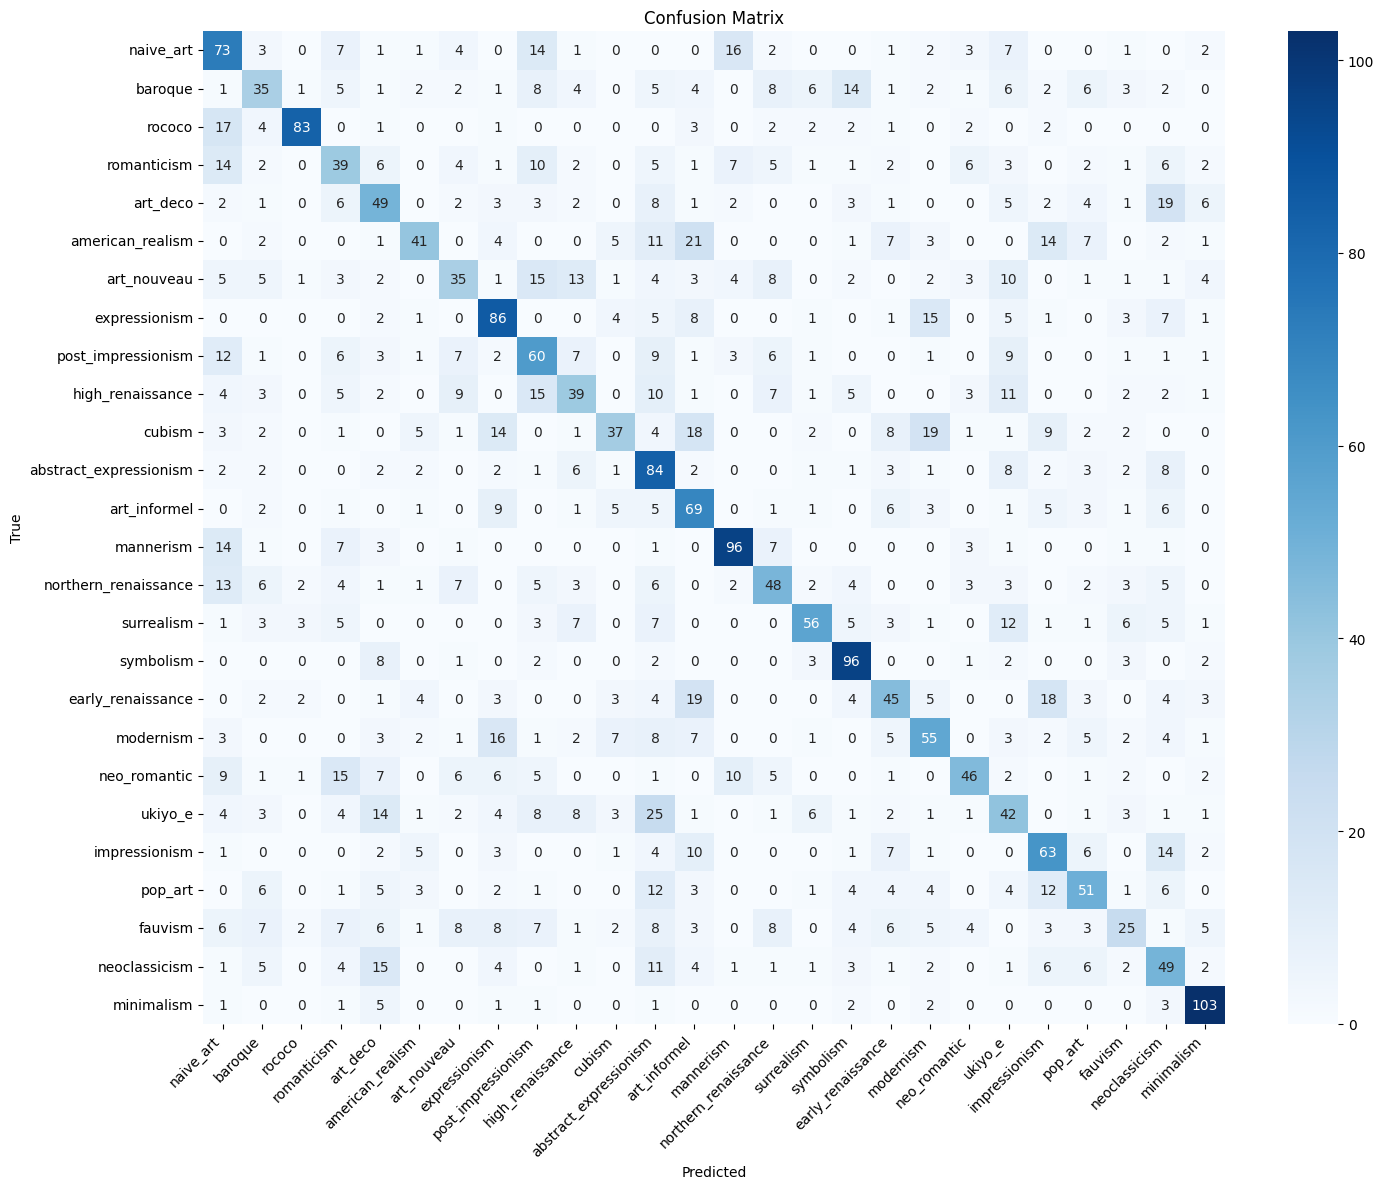

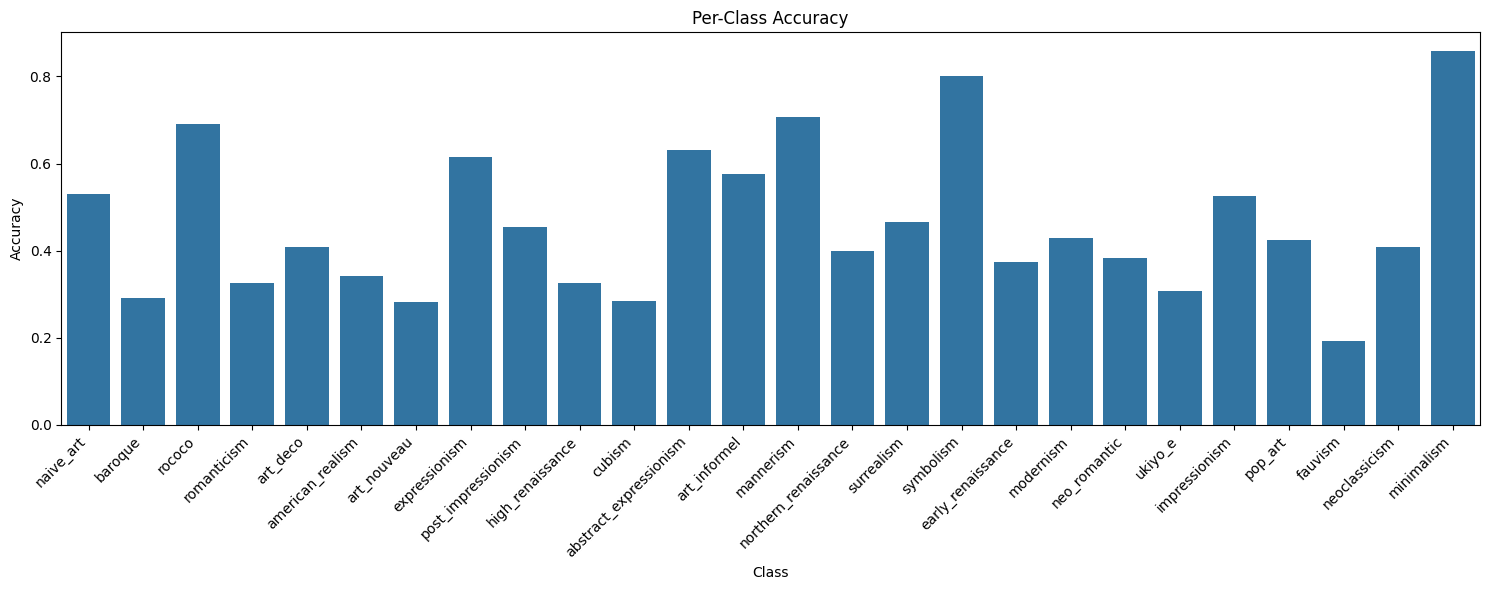


Top 10 Misclassifications:
1. True: ukiyo_e → Predicted: abstract_expressionism (Count: 25)
2. True: american_realism → Predicted: art_informel (Count: 21)
3. True: art_deco → Predicted: neoclassicism (Count: 19)
4. True: cubism → Predicted: modernism (Count: 19)
5. True: early_renaissance → Predicted: art_informel (Count: 19)
6. True: cubism → Predicted: art_informel (Count: 18)
7. True: early_renaissance → Predicted: impressionism (Count: 18)
8. True: rococo → Predicted: naive_art (Count: 17)
9. True: naive_art → Predicted: mannerism (Count: 16)
10. True: modernism → Predicted: expressionism (Count: 16)


In [91]:



def evaluate_model_per_class(model, X_test, y_test_cat, class_names):
    """
    Evaluate model performance for each class with detailed metrics and visualizations.

    Parameters:
    model: Trained Keras model
    X_test: Test data
    y_test_cat: One-hot encoded test labels
    class_names: List of class names
    """
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("Classification Report:")
    print(report_df.round(3))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

    # Plot per-class accuracy
    plt.figure(figsize=(15, 6))
    sns.barplot(x=class_names, y=per_class_accuracy)
    plt.title('Per-Class Accuracy')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot top misclassifications
    misclassification_matrix = cm.copy()
    np.fill_diagonal(misclassification_matrix, 0)
    top_misclassifications = []

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j:
                top_misclassifications.append({
                    'true': class_names[i],
                    'predicted': class_names[j],
                    'count': misclassification_matrix[i, j]
                })

    top_misclassifications.sort(key=lambda x: x['count'], reverse=True)

    # Print top 10 misclassifications
    print("\nTop 10 Misclassifications:")
    for i, misc in enumerate(top_misclassifications[:10]):
        print(f"{i+1}. True: {misc['true']} → Predicted: {misc['predicted']} "
              f"(Count: {misc['count']})")

    return report_df, cm, per_class_accuracy

# Run the evaluation
report_df, confusion_mat, class_accuracies = evaluate_model_per_class(
    model, X_test, y_test_cat, unique_styles
)

After testing and evaluating various model architectures I settled on the model with near the highest validation accuracy but with the smallest gap between train and validation accuracy, going for a model that will generalize as well as possible.

Despite the relatively low accuracy, with 26 classes the model still performs much better than random guessing

Techniques that improved model performance:
Adding BatchNormalization layer
Dropout layers
Early Stopping
Learning Rate Schedule
Using a GAP layer instead of flatten
Increased the filters in the Conv2d layers
with appropriate increases in the Dense layers
Dropping 'contemporary' class

Techniques that did not improve model performance:
Adding too many Conv2d layers with more filters
Implementing resnet connections
changing optimizer to AdamW
using leaky relu

Areas for improvement:
Adjust learning rate schedule
Adjust dropout rates
Adjust filters and Conv2d layers


In [94]:
# Save the model architecture and weights
model.save('/content/drive/MyDrive/art_classifier_best.keras')

# To later load the model:
#loaded_model = keras.models.load_model('/content/drive/MyDrive/art_classifier_best.keras')
